In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Linear Quadratic System and Variations

## 1. LQR in LTI (Linear Time Invarient) System

### 1.1 Formulation

The time-invariant LQ system assumes following two conditions for $t = 1,2, ..., H$.

- **time-invariant linear dynamical system (LTI)**
$$x_{t+1} = Ax_t + Bu_t$$
    
- **quadratic cost function**
$$c(x_t, u_t) = {x_t}^\top Qx_t + {u_t}^\top Ru_t$$


We would like to solve the optimal control problem shown below.

$$\min_{x,u} \sum_{t=0}^{H-1} ({x_t}^\top  Q x_t + {u_t}^\top  R u_t) \\ \text{s.t. }x_{t+1} = A x_t + B u_t$$

*In the case of the infinite horizon problem, $H$ is infinity*

In [2]:
class LTIEnv(object):
    def __init__(self, A, B, Q, R, x_init):
        self.A = A
        self.B = B
        self.x_dim = self.A.shape[0]
        self.u_dim = self.B.shape[1]
        self.Q = Q
        self.R = R
        self.x_init = x_init
        self.x_curr = x_init
        self.t = 0
        
    def controllable(self):
        # controllability matrix
        C = [self.B]
        for i in range(self.x_dim):
            C.append(self.A @ C[-1])
        return np.linalg.matrix_rank(np.hstack(C)) == x_dim

    def step(self, u, noise=None):
        if noise is not None:
            assert noise.shape == self.x_curr.shape
            x = self.A @ self.x_curr + self.B @ u + noise
        else:
            x = self.A @ self.x_curr + self.B @ u
        c = self.x_curr.T @ self.Q @ self.x_curr + u.T @ self.R @ u # cost
        self.x_curr = x.copy()
        self.t += 1
        return x, c

    def get_state(self):
        return self.x_curr.copy()
    
    def set_state(self, x):
        self.x_curr = x.copy()

    def reset(self):
        self.t = 0
        self.x_curr = self.x_init.copy()
        
# helper function for generating a PSD
def generate_PSD(dim):
    X = np.random.rand(dim, dim)
    return X @ X.T

In [3]:
x_dim = 4 # state dimension
u_dim = 3 # action dimension

lti_env = LTIEnv(A=np.random.randn(x_dim, x_dim),
                 B=np.random.randn(x_dim, u_dim),
                 Q=generate_PSD(x_dim),
                 R=generate_PSD(u_dim),
                 x_init=np.array([-1.9613, 1.9277, -0.2442, 0.1234]))

if lti_env.controllable:
    print("this env is controllable")
else:
    print("this env is not controllable; reinitialize the environment.")

this env is controllable


### 1.2 Solution with Value Iteration

We first define a cost-to-go function $J_i$ in order to find a optimal policy for a $i$-step horizon.

$$J_{i+1}(x) = \min_u[x^\top Qx + u^\top  Ru + J_i(Ax + Bu)]$$ 

Then, by setting the gradient w.r.t $u$ to zero, we get the following result.

for $i=1,2,3,...$

- **optimal policy**
    - $\pi(x) = K_{i}x$, where
      $$K_{i} = -(R + B^{\top} P_{i-1} B)^{-1} B^{\top} P_{i-1} A$$
    
    
- **quadratic cost function**
    - $J_i(x) = x^\top P_{i}x$, where
      $$P_i = Q + {K_i}^{\top}R K_i + (A + B K_i)^{\top} P_{i-1} (A + B K_i)$$
    
**$P_0 = 0$*

In [4]:
def lqr_infinite(lti_env, threshold=1e-4):
    A = lti_env.A
    B = lti_env.B
    Q = lti_env.Q
    R = lti_env.R
    x_dim = lti_env.x_dim
    u_dim = lti_env.u_dim
    
    P, K_current = np.eye(x_dim), np.zeros((u_dim, x_dim))
    while True:
        K_new = -np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A
        if np.linalg.norm(K_new - K_current) <= threshold:
            break
        else:
            K_current = K_new
            P = Q + K_current.T @ R @ K_current + (A + B @ K_current).T @ P @ (A + B @ K_current)
    return K_new, P
    

### 1.3 Experiment

In [5]:
K_inf, P = lqr_infinite(lti_env)

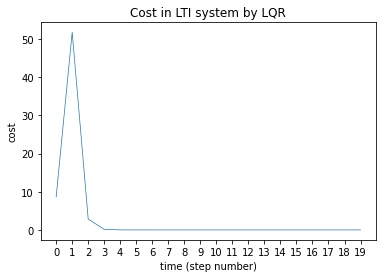

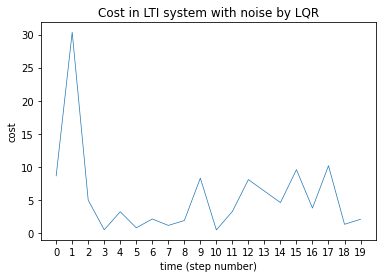

In [6]:
# simulate the forward pass and plot the cost over time
def lti_simulate(lti_env, K, H, noise=False):
    lti_env.reset() 
    costs = []
    x = lti_env.get_state()
    for t in np.arange(H):
        u = K @ x
        if noise:
            x, c = lti_env.step(u, noise=0.7 * np.random.rand(lti_env.x_dim))
        else:
            x, c = lti_env.step(u)
        costs.append(c)
    plt.plot(costs, linewidth=.7)
    
    if noise:
        plt.title('Cost in LTI system with noise by LQR')
    else:
        plt.title('Cost in LTI system by LQR')
    
    plt.xlabel('time (step number)')
    plt.xticks(np.arange(20))
    plt.ylabel('cost')
    plt.show()
        

H = 20 # simulating for 20 steps
lti_simulate(lti_env, K_inf, H)
lti_simulate(lti_env, K_inf, H, noise=True)

# write cost or l2 norm of x
# write unit (discrete) 

## 2. LQR in LTI (Linear Time Invarient) System

### 2.1 Formulation

The time-invariant LQ system assumes following two conditions for $t = 1,2, ..., H$.

- **time-variant linear dynamical system (LTV)**
$$x_{t+1} = A_t x_t + B_t u_t$$
    
- **quadratic cost function**
$$c(x_t, u_t) = {x_t}^\top Q_t x_t + {u_t}^\top R_t u_t$$

We would like to solve the optimal control problem shown below.

$$\min_{x,u} \sum_{t=1}^H (x_t^\top Q_t x_t + u_t^\top R_t u_t)  \\ \text{s.t. }x_{t+1} = A_t x_t + B_t u_t$$

In [7]:
# Q and R are fixed in this implementation
class LTVEnv(object):
    def __init__(self, A_lst, B_lst, Q, R, x_init):
        self.A_lst = A_lst
        self.B_lst = B_lst
        self.x_dim = self.A_lst[0].shape[0]
        self.u_dim = self.B_lst[0].shape[1]
        self.Q = Q
        self.R = R
        self.x_init = x_init
        self.x_curr = x_init
        # self.T = len(self.A_lst)
        self.t = 0

    def step(self, u, noise=None):
        if noise is not None:
            assert noise.shape == self.x_curr.shape
            x = self.A_lst[self.t] @ self.x_curr + self.B_lst[self.t] @ u + noise
        else:
            x = self.A_lst[self.t] @ self.x_curr + self.B_lst[self.t] @ u
        c = self.x_curr.T @ self.Q @ self.x_curr + u.T @ self.R @ u # cost
        self.x_curr = x.copy()
        self.t += 1
        return x, c

    def get_state(self):
        return self.x_curr.copy()
    
    def set_state(self, x):
        self.x_curr = x.copy()

    def reset(self):
        self.t = 0
        self.x_curr = self.x_init.copy()
        
# helper function for generating a PSD
def generate_PSD(dim):
    X = np.random.rand(dim, dim)
    return X @ X.T

In [8]:
x_dim = 4 # state dimension
u_dim = 3 # action dimension

H = 50
A_lst = [np.array([[np.sin(t), -0.5049, 0.0299, 1 - 1/(1+t)**2],
              [2*np.cos(t), -0.2312, -np.sin(t), -0.7945],
              [-0.0254, 0.4595, -0.0862, 2.1750],
              [0.5172, 0.5060, np.cos(t), -0.9407]]) for t in range(H)]
B_lst = [np.array([[-0.7789, np.cos(t), -1.2076],
              [0.4299, -2*np.cos(t), np.sin(t)],
              [3*np.sin(t), 0.8302, 0.2295],
              [-1.8465, np.cos(t), 0.3241]]) for t in range(H)]

ltv_env = LTVEnv(A_lst=A_lst,
                 B_lst=B_lst,
                 Q=generate_PSD(x_dim),
                 R=generate_PSD(u_dim),
                 x_init=np.array([-1.9613, 4.3127, -0.9442, 2.1234]))

### 2.2 Solution with Value Iteration

We first define a cost-to-go function $J_i$ in order to find a optimal policy for a $i$-step horizon.

$$J_{i+1}(x) = \min_u[x^\top Q_t x + u^\top  R_t u + J_i(A_t x + B_t u)]$$ 

Then, by setting the gradient w.r.t $u$ to zero, we get the following result.

for $i=1,2,3,...$

- **optimal policy**
    - $\pi(x) = K_{i}x$, where
      $$K_{i} = -(R_{H-i} + B^{\top}_{H-i} P_{i-1} B_{H-i})^{-1} B_{H-i}^{\top} P_{i-1} A_{H-i}$$
    
    
- **quadratic cost function**
    - $J_i(x) = x^\top P_{i}x$, where
      $$P_i = Q_{H-i} + {K_i}^{\top}R_{H-i} K_i + (A_{H-i} + B_{H-i} K_i)^{\top} P_{i-1} (A_{H-i} + B_{H-i} K_i)$$
    
**$P_0 = 0$*

In [9]:
def lqr_finite(ltv_env):
    
    A_lst = ltv_env.A_lst
    B_lst = ltv_env.B_lst
    Q = ltv_env.Q
    R = ltv_env.R
    x_dim = ltv_env.x_dim
    u_dim = ltv_env.u_dim
    H = len(A_lst)
    
    K_lst, P_lst= [], []    
    P_lst.append(np.zeros((x_dim, x_dim)))
    K_lst.append(np.zeros((u_dim, x_dim)))
    
    for t in range(1, H+1):
        A = A_lst[H-t]
        B = B_lst[H-t]
        Q = Q
        R = R
        K_t = -np.linalg.inv(R + B.T @ P_lst[t-1] @ B) @ B.T @ P_lst[t-1] @ A
        P_t = Q + K_t.T @ R @ K_t + (A + B @ K_t).T @ P_lst[t-1] @ (A + B @ K_t)
        K_lst.append(K_t) 
        P_lst.append(P_t)
    
    K_lst = K_lst[1:]
    P_lst = P_lst[1:]
    
    return K_lst, P_lst

### 2.3 Experiment

In [10]:
K_lst, P_lst = lqr_finite(ltv_env)

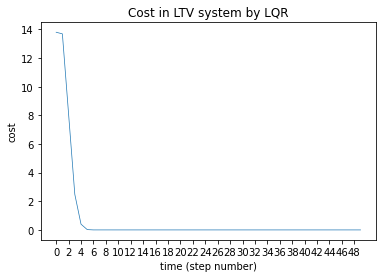

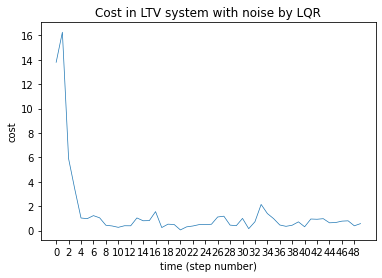

In [11]:
# simulate the forward pass and plot the cost over time
def ltv_simulate(ltv_env, K_lst, H, noise=False):
    ltv_env.reset() 
    costs = []
    x = ltv_env.get_state()
    for t in np.arange(H):
        u = K_lst[H-t-1] @ x
        if noise:
            x, c = ltv_env.step(u, noise=0.3 * np.random.rand(ltv_env.x_dim))
        else:
            x, c = ltv_env.step(u)
        costs.append(c)
    plt.plot(costs, linewidth=.7)
    
    if noise:
        plt.title('Cost in LTV system with noise by LQR')
    else:
        plt.title('Cost in LTV system by LQR')
    
    plt.xlabel('time (step number)')
    plt.xticks(np.arange(0, H, 2))
    plt.ylabel('cost')
    plt.show()
        
ltv_simulate(ltv_env, K_lst, H)
ltv_simulate(ltv_env, K_lst, H, noise=True)

# # write cost or l2 norm of x
# # write unit (discrete) 

# T = 50
# A_lst = [np.array([[np.sin(t), -0.5049, 0.0299, 2.6544],
#               [2.3846, -0.2312, -0.1260, -0.7945],
#               [-0.0254, 0.4595, -0.0862, 2.1750],
#               [0.5172, 0.5060, 1.6579, -0.9407]]) for t in range(T)]
# B_lst = [np.array([[-0.7789, np.cos(t), -1.2076],
#               [0.4299, -1.6041, np.sin(t)],
#               [3*np.sin(t), 0.8302, 0.2295],
#               [-1.8465, np.cos(t), 0.3241]]) for t in range(T)]

# starting_states = np.array([[-1.9613, 1.9277, -0.2442],
#                             [-1.3127, -0.2406, -0.0260],
#                             [0.0698, -0.5860, -0.7522],
#                             [0.0935, -0.1524, -0.9680]])
# n_starting_states = starting_states.shape[1]

# K_lst, P_lst = lqr_finite(A_lst, B_lst, Q, R, T)

# def simulate(A_lst, B_lst, K_list, n_starting_states, T, noise=None):
#     for s in np.arange(n_starting_states):
#         x, u = np.zeros((K_list[0].shape[1], T+1)), np.zeros((K_list[0].shape[0], T+1))
#         x[:,0] = starting_states[:,s]
#         for t in np.arange(T):
#             u[:,t] = K_lst[T-t-1] @ x[:,t]
#             x[:,t+1] = A_lst[t] @ x[:,t] + B_lst[t] @ u[:,t]
#             if noise is not None:
#                 x[:,t+1] += noise[:,t]
#         plt.plot(x.T, linewidth=.7)
#         plt.plot(np.squeeze(u.T), linewidth=.7, linestyle='--')
#         legend_elements = [Line2D([0], [0], label='x'),Line2D([0], [0], linestyle='--', label='u')]
#         plt.legend(handles=legend_elements)
#         plt.xlabel('time')
#         plt.show()

# simulate(A_lst, B_lst, K_lst, n_starting_states, T)

## 3. Trajectory Following in a Nonlinear System

### 3.1 Formulation

- **nonlinear dynamical system**
$$x_{t+1} = f(x_t, u_t)$$
    
- **quadratic cost function**
$$c(x_t, u_t) = {x_t}^\top Qx_t + {u_t}^\top Ru_t$$

Given a feasible trajectory $\{ x_t^*, u_t^*\}_{t=0}^{H-1}$ , we define our optimization problem as follows:

$$\min_{u_0, ..., u_{H-1}} \sum_{t=0}^{H-1} (((x_t-x_t^*)\top Q_t (x_t-x_t^*) + (u_t-u_t^*)\top R_t (u_t-u_t^*))) \\ \text{s.t. }x_{t+1} = f(x_t, u_t)$$

**first LTV, then non-linear**

**say it on the math, saying q: psd, r: pd** 


lti, ltv - check answer to test my code.

### 3.2 Solution with Linearization and Value Iteration

For each time step, we estimate linearize the system by computing the Jacobian around the target point $(x_t^*, u_t^*)$. By doing so, we can transfrom the problem into a linear time varying (LTV) case.

In [12]:
class NonLinearEnv(object):
    def __init__(self, f, Q, R, x_init, target_traj):
        self.f = f
        self.Q = Q
        self.R = R
        self.x_dim = self.Q.shape[0]
        self.u_dim = self.R.shape[0]
        self.target_traj = target_traj
        self.x_init = x_init
        self.x_curr = x_init
        self.t = 0

    def step(self, u, noise=None):
        if noise is not None:
            assert noise.shape == self.x_curr.shape
            x = f(self.x_curr, u) + noise
        else:
            x = f(self.x_curr, u)
            
        if self.target_traj is not None:
            x_target = target_traj[0][t]
            u_target = target_traj[1][t]
    
            c = (self.x_curr-x_target).T @ self.Q @ (self.x_curr-x_target) + \
                (u-u_target).T @ self.R @ (u-u_target) # cost         
        else:
            c = self.x_curr.T @ self.Q @ self.x_curr + u.T @ self.R @ u # cost
        self.x_curr = x.copy()
        self.t += 1
        return x, c

    def get_state(self):
        return self.x_curr.copy()
    
    def set_state(self, x):
        self.x_curr = x.copy()
        
    def reset(self):
        self.t = 0
        self.x_curr = self.x_init.copy()
        
    def linearize_dynamics(self, eps):
        A = np.zeros((self.x_dim, self.x_dim))
        B = np.zeros((self.x_dim, self.u_dim))
        x_target = target_traj[0][t]
        u_target = target_traj[1][t]
        x_target_next = target_traj[0][t+1]
        
        
        for i in range(dx):
            delta_x = np.zeros(dx)
            delta_x[i] = eps
            A[:, i] = (self.f(x_target+delta_x, u_target, dt) - self.f(x_target, u_target, dt)) / eps

        for j in range(du):
            delta_u = np.zeros(du)
            delta_u[j] = eps
            B[:, j] = (self.f(x_target, u_target+delta_u, dt) - self.f(x_target, u_target, dt)) / eps

        c = f(x_target, u_target, dt) - x_target_next
        
        return A, B, c


In [14]:
x_dim = 4 # state dimension
u_dim = 3 # action dimension

def random_nonlinear_func(x, u, x_dim=4, u_dim = 3):
    A = generate_PSD(x_dim)
    B = generate_PSD(u_dim)
    C = np.random.randn(x_dim, x_dim)
    D = np.random.randn(x_dim, u_dim)
    return (x.T @ A @ x + u.T @ B @ u) * x + C @ x + D @ u - 2 * u.T @ B @ u * np.sin(x)

nonlinear_env = NonLinearEnv(f=random_nonlinear_func,
                             Q=generate_PSD(x_dim),
                             R=generate_PSD(u_dim),
                             x_init=np.array([-1.9613, 1.9277, -0.2442, 0.1234]))


In [ ]:
def lqr_nonlinear(nonlinear_env): 
    for t in range(T-1):
        A, B, c = linearize_dynamics(f, x_ref[t], u_ref[t], dt, my_eps, 
                                     x_ref_tplus1=x_ref[t+1])
        A_t = np.append(np.append(A, 
                                  np.zeros(A.shape[1]).reshape(1, -1), 
                                  axis=0), 
                        np.append(c, 1).reshape(1, -1).T,
                        axis=1)    
        B_t = np.append(B, 
                        np.zeros(B.shape[1]).reshape(1, -1), 
                        axis=0)
        A_lst.append(A_t)
        B_lst.append(B_t)

        Q = Q
        R = R
        K_t = -np.linalg.inv(R + B.T @ P_lst[t-1] @ B) @ B.T @ P_lst[t-1] @ A
        P_t = Q + K_t.T @ R @ K_t + (A + B @ K_t).T @ P_lst[t-1] @ (A + B @ K_t)
        K_lst.append(K_t) 
        P_lst.append(P_t)
    
    K_lst = K_lst[1:]
    P_lst = P_lst[1:]
    
    return K_lst, P_lst